In [9]:
import cv2
import os
import numpy as np
import pandas as pd
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import math

In [10]:
# for i in range(1,22,3):
#     img_path = "C:/workspace/cakd3/team2/data/BoneAge/BA_total/"
#     save_path = "C:/workspace/cakd3/team2/data/sample/"
#     img = cv2.imread(img_path+f"{i}.jpg", 0)
#     img_ro = preprocession_img_ro(img)
#     cv2.imwrite(save_path+f"{i}.jpg", img_ro)

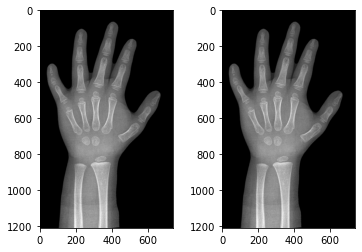

In [11]:
# 회전 확인
img = "C:/workspace/cakd3/team2/data/BoneAge/BA_total/2.jpg"
img = cv2.imread(img, 0)
img_ro = preprocession_img_ro(img)
img_plt(img_ro)

In [1]:
# 회전 확인할때 쓴 사용자함수.
def img_plt(img):
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(img, cmap='gray')
    plt.show()

In [2]:
# 아래의 사용자함수 다 실행시키시면 됩니다.
def preprocession_img_ro(img):
    mask = make_mask(img)
    masked = cut_mask(img, mask)
    img_ro = masked_ro(masked)
    return img_ro

In [3]:
# 1기 전처리 회전까지 합쳐놓은 사용자함수
# 마스크 만들기
def make_mask(img):
    #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환 01
    img1 = img.copy()
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)
    
    #블러 02
    #블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
    blur_k = int((img1.mean()*0.5)//2)*2+1
    img1 = cv2.medianBlur(img1, blur_k)
    
    # threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환 03
    img1 = cv2.cvtColor(img1, cv2.COLOR_Lab2BGR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    #이미지 평균값을 기준으로 이진화 04
    ret, img1 = cv2.threshold(img1, img1.mean()*1.1, 255, cv2.THRESH_BINARY)
    
    #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img1.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    # 커널만들어서 팽창연상 적용
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k) #팽창연산
    
    return mask
# --------------------------------------------------------------------
# 마스크 기준으로 자르기
def cut_mask(img, mask):
    img2 = img.copy()
    height, width = img2.shape[:2]
    mask_list = mask.tolist()
    
    for y in range(int(height*0.05),height):
        if max(mask[y,int(width*0.3):int(width*0.7)]) > 0:
            start_y = y-int(height*0.05)
            break
            
    for x in range(int(width*0.05),width):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            start_x = x-int(width*0.05)
            break
            
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break
            
    cut_index = 0
    if mask_list[height-1][-1] == 255 or mask_list[height-1][0] == 255:
        for n in reversed(range(height)):
            if mask_list[n][0] == 0 or mask_list[n][-1] == 0:
                cut_index = n
                break
                
    if cut_index == 0:
        cut_index = height

    img = img[start_y:(cut_index-1),start_x:end_x]
    mask = mask[start_y:(cut_index-1),start_x:end_x]
    masked = cv2.bitwise_and(img, mask) #이미지에서 배경을 지우는 연산

    return masked


#-------------------------------------------------
# 배경 지운 이미지 회전
def masked_ro(img):
    img3 = img.copy()
    h, w = img3.shape[:2]
    img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_li = th.tolist()

    # 회전 1단계
    # 밑에서부터 처음으로 검은 색이 나오는 부분이 lower
    for i in reversed(range(h)):
        if th_li[i][0] == 0 and th_li[i][-1] == 0:
            lower = i
            break

    # 만약 맨 밑이 lower면 이미지의 95퍼센트 부분을 lower로 정의
    if lower == h - 1:
        lower = int(h*0.9)

    # upper는 lower에서 5퍼센트만큼 올라간 부분
    slice5 = int(len(th)*0.05)
    upper = lower - slice5

    # x, y좌표들은 이미지의 90퍼센트(upper)와 95퍼센트(lower) 부분의 손목 가운데 지점들
    x,y = [],[]
    for i in range(slice5):
        cnt = th_li[i + upper].count(255)
        index = th_li[i + upper].index(255)
        x.append([i+upper])
        y.append([int((index*2 + cnt - 1)/2)])

    # x,y좌표로 단순선형회귀 그리기
    model = LinearRegression()
    model.fit(X=x,y=y)

    # -----------------------------------------------------------------------------------
    # 회전 2단계
    angle = math.atan2(h - 0, int(model.predict([[h]])) - int(model.predict([[0]])))*180/math.pi
    M = cv2.getRotationMatrix2D((w/2,h/2), angle-90, 1)
    rotate = cv2.warpAffine(img3, M, (w, h))

    # 회전한 부분을 자르기
    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            start_x = i
            break

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            end_x = i

    s_point = h - int((int(model.predict([[h]])-start_x)) * math.tan(math.pi*((90-angle)/180)))
    e_point = h - int((end_x - int(model.predict([[h]]))) * math.tan(math.pi*((angle-90)/180)))
    point = max(s_point, e_point)
    img_ro = rotate[:point]
    return img_ro